In [2]:
import pandas as pd
import numpy as np
import math

# Finance
import mplfinance as mpf
import ta
import yfinance as yf

import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from torch.optim import Adam

import matplotlib.pyplot as plt
import shap



# System
from dotenv import load_dotenv
import os
from pathlib import Path
import requests
import sys
import time

sys.path.append('../') # Change the python path at runtime
from src.utils import path as path_yq



/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()
cur_dir = Path.cwd()

POLYGON_API_KEY = os.environ.get("POLYGON_API_KEY")
DEVICE = torch.device('mps')


# Fetch Tick Data
- Add feature to pull from data instead of fetching

## Polygon API

In [ ]:
# TODO: Scale this up to n years
ticker = "NVDA"
max_limit = 50000
start_date = "2000-01-01"
end_date = "2024-12-31"

api_url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit={max_limit}&apiKey={POLYGON_API_KEY}"



In [ ]:
str = "N" # Reset
str = input("Confirm?")

if str == "Y":
    resp = requests.get(api_url)
    print(f"Request made.")

In [ ]:
resp

In [ ]:
cols = ["Date", "Open", "High", "Low", "Close", "Volume", "VWAP", "Transactions"]
if resp.status_code == 200:
    dict_list = resp.json().get('results')
    df = pd.DataFrame(dict_list)

    column_map = {
        't': 'Timestamp',
        'o': 'Open',
        'h': 'High',
        'l': 'Low',
        'c': 'Close', 
        'n': 'Transactions', # Number of trades (market activity)
        'v': 'Volume', # Number of shares traded (intensity of the activity)
        'vw': 'VWAP'
    }

    df.rename(columns=column_map, inplace=True)

    df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')
    df['Date'] = df['Datetime'].dt.normalize() # Remove the time and return date object

    df = df[cols]
    df.set_index(keys="Date", inplace=True)
else:
    print(f"Error fetching data: {resp.status_code}, {resp.text}")

In [ ]:
df

## Yfinance

In [ ]:
import seaborn as sns
historical_start_date = '2022-08-09'
# Define the ticker list
# Capitaland A17U, SUNT.SI cannot download
ticker_list = ['S51.SI']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.index = pd.to_datetime(data.index)
display(data.tail(20))
data.plot()

plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [ ]:
df


## Read Data

In [ ]:
root_dir = path_yq.get_root_dir(cur_dir=cur_dir)
csv_path = Path.joinpath(root_dir, "data", f"{ticker}_{start_date}_{end_date}.csv")

# Get df
try:
    df.to_csv(csv_path)
except NameError:
    print(f"df not defined, trying to fetch from csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # Convert data
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index(keys="Date", inplace=True)

In [ ]:
df.tail(6)

mpf plot: https://github.com/matplotlib/mplfinance?tab=readme-ov-file

In [ ]:
mpf.plot(df, type='candle', style='charles', figsize=(20, 10), title="OHLC Bars for NVDA", volume=True, show_nontrading=True, mav=(3, 6, 9))

In [ ]:
df.isna().sum()


## Read and Preprocess Bryan's Data


In [45]:
csv_path = Path.joinpath(path_yq.get_root_dir(cur_dir=cur_dir), 'data', 'capitaland.csv')
df2 = pd.read_csv(csv_path)
df2['Date'] = pd.to_datetime(df2['Date']).dt.normalize()

assert (df2.index == df2.sort_values(by='Date', ascending=True).index).all(), 'df is not sorted in ascending'
df2['Year'] = df2.Date.dt.year
df2['Month'] = df2.Date.dt.month
df2['Day'] = df2.Date.dt.day

if input('Add additional features?') == 'Y':
    # Testing additional features
    df2['BB High'], df2['BB Low']= ta.volatility.bollinger_hband(df2['A17U.SI_Close']), ta.volatility.bollinger_lband(df2['A17U.SI_Close'])

    df2['MA_50'] = df2['A17U.SI_Close'].rolling(window=50).mean()

    df2['MA_20'] = df2['A17U.SI_Close'].rolling(window=20).mean()

    df2['MA_5'] = df2['A17U.SI_Close'].rolling(window=5).mean()
df2.drop(columns='Date', inplace=True)
df2.dropna(inplace=True)
print(df2.isna().sum())

df2

A17U.SI_Open          0
A17U.SI_High          0
A17U.SI_Low           0
A17U.SI_Close         0
A17U.SI_Volume        0
A17U.SI_Dividends     0
A17U.SI_Next_Close    0
Year                  0
Month                 0
Day                   0
BB High               0
BB Low                0
MA_50                 0
MA_20                 0
MA_5                  0
dtype: int64


,A17U.SI_Open,A17U.SI_High,A17U.SI_Low,A17U.SI_Close,A17U.SI_Volume,A17U.SI_Dividends,A17U.SI_Next_Close,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5
49,2.484414,2.509939,2.484414,2.509939,9607100,0.01678,2.526956,2021,3,15,2.628244,2.410352,2.568054,2.519298,2.462292
50,2.526956,2.543972,2.509939,2.526956,11248900,0.01678,2.595021,2021,3,16,2.615485,2.414603,2.568160,2.515044,2.482712
51,2.560988,2.620546,2.560988,2.595021,20429700,0.01678,2.612038,2021,3,17,2.613618,2.415618,2.569797,2.514618,2.515044
52,2.620546,2.629054,2.595021,2.612038,21741400,0.01678,2.620546,2021,3,18,2.615629,2.414459,2.570759,2.515044,2.543972
53,2.603530,2.629054,2.586513,2.620546,25158700,0.01678,2.620546,2021,3,19,2.621475,2.411165,2.572398,2.516320,2.572900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2.800000,2.830000,2.770000,2.770000,9167500,0.07441,2.780000,2024,3,28,2.781218,2.652782,2.752969,2.717000,2.758000
814,2.770000,2.790000,2.750000,2.780000,5550600,0.07441,2.760000,2024,4,1,2.789857,2.650143,2.752299,2.720000,2.766000
815,2.780000,2.790000,2.750000,2.760000,11393700,0.07441,2.730000,2024,4,2,2.794000,2.650000,2.751424,2.722000,2.770000
816,2.750000,2.750000,2.720000,2.730000,12905200,0.07441,2.740000,2024,4,3,2.794861,2.651139,2.749171,2.723000,2.762000


# Features
- Technical indicators
- Fundamental indicators
- Date features
- Holiday indicators etc.

# Preprocessing
- Train-test split
- Scale data (only fit-transform for train, but not for test)
- Decide which to predict. Have open and predict the close for the same day? Have the close for the previous day and predict next open?

In [5]:
def create_technical_indicators(tmp: pd.DataFrame):
    df = tmp.copy(deep=True)

    # Date features
    # df['Year'], df['Month'], df['Day'] = df.index.year, df.index.month, df.index.day
    # FIXME: Test no date
    # Use the close price to create the indicators
    df['BB High'], df['BB Low']= ta.volatility.bollinger_hband(df['Close']), ta.volatility.bollinger_lband(df['Close'])
    
    # Takes the past 20 data, including the current one to calculate the mean
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    df['MA_20'] = df['Close'].rolling(window=20).mean()

    df['MA_5'] = df['Close'].rolling(window=5).mean()

    df['Future Close'] = df['Close'].shift(-1)

    return df

In [ ]:
df2 = create_technical_indicators(tmp=df)

In [ ]:
df2

In [8]:
df2.dropna(inplace=True)
# Removes the row that doesn't have a target also
df2

,A17U.SI_Open,A17U.SI_High,A17U.SI_Low,A17U.SI_Close,A17U.SI_Volume,A17U.SI_Dividends,A17U.SI_Next_Close,BB High,BB Low,MA_50,MA_20,MA_5
49,2.484414,2.509939,2.484414,2.509939,9607100,0.01678,2.526956,2.628244,2.410352,2.568054,2.519298,2.462292
50,2.526956,2.543972,2.509939,2.526956,11248900,0.01678,2.595021,2.615485,2.414603,2.568160,2.515044,2.482712
51,2.560988,2.620546,2.560988,2.595021,20429700,0.01678,2.612038,2.613618,2.415618,2.569797,2.514618,2.515044
52,2.620546,2.629054,2.595021,2.612038,21741400,0.01678,2.620546,2.615629,2.414459,2.570759,2.515044,2.543972
53,2.603530,2.629054,2.586513,2.620546,25158700,0.01678,2.620546,2.621475,2.411165,2.572398,2.516320,2.572900
...,...,...,...,...,...,...,...,...,...,...,...,...
813,2.800000,2.830000,2.770000,2.770000,9167500,0.07441,2.780000,2.781218,2.652782,2.752969,2.717000,2.758000
814,2.770000,2.790000,2.750000,2.780000,5550600,0.07441,2.760000,2.789857,2.650143,2.752299,2.720000,2.766000
815,2.780000,2.790000,2.750000,2.760000,11393700,0.07441,2.730000,2.794000,2.650000,2.751424,2.722000,2.770000
816,2.750000,2.750000,2.720000,2.730000,12905200,0.07441,2.740000,2.794861,2.651139,2.749171,2.723000,2.762000


## Scale, Load Dataset

In [ ]:
start_time = time.time()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time is {elapsed_time:3f}s.")

In [35]:
class Scaler:
    def __init__(self, type='standard') -> None:
        self.scaler = None
        if type == 'standard':
            self.scaler = StandardScaler()
        elif type == 'minmax':
            self.scaler = MinMaxScaler()
        
    def scale_fit_transform(self, train, val):
        train_scaled = self.scaler.fit_transform(train)
        val_scaled = self.scaler.transform(val)

        return train_scaled, val_scaled

    def scale_transform(self, test):
        return self.scaler.transform(test)


# def scale(X_train, X_val, type='standard'):
#     """
#     Scale based on the train and val/test data with a specific type.
#     """
#     type = 'standard'
#     if type == 'standard':
#         scaler = StandardScaler()
#     else:
#         scaler = MinMaxScaler()

#     X_train_scaled = scaler.fit_transform(X_train)
#     X_val_scaled = scaler.transform(X_val)

#     return X_train_scaled, X_val_scaled

In [ ]:
def convert_numpy_torch(arr) -> torch:
    if isinstance(arr, (pd.DataFrame, pd.Series)):
        arr = arr.to_numpy()
    if isinstance(arr, np.ndarray):
        # This does not make a copy, but any changes will affect the original arr
        # Alternative: torch.tensor(arr, dtype=torch.float32)
        return torch.from_numpy(arr).float().to(DEVICE) # Ensure it is a float tensor, and move to device
    else:
        raise ValueError(f"The input\n{arr}\nis not an ndarray, it is a {type(arr)}.")

# Only X needs to be turned into a sequence
def load_sequence(X, seq_len):
    sequences = []
    for i in range(len(X) - seq_len):
        sequences.append(X[i: i + seq_len])
    # print(np.array(sequences).shape)
    return np.array(sequences)

def load_data(X, y, batch_size, shuffle):
    dataset = TensorDataset(convert_numpy_torch(X),
                                convert_numpy_torch(y))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


# Model Class

In [37]:
class EarlyStopper:
    def __init__(self, patience=5):
        self.min_loss = np.inf
        self.patience = patience
        self.counter = 0
        self.delta = 0 # TODO: Might wanna adjust based on stock volatility

    def stop(self, loss: float) -> bool:
        if loss < self.min_loss - self.delta:
            self.min_loss = loss
            # Reset counter
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



LSTM self-define ReLU: https://discuss.pytorch.org/t/change-tanh-activation-in-lstm-to-relu/14160

In [89]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size=None, num_layers=None, **kwargs):
        super().__init__() # Need bracket for super
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = 1
        self.bidir = False # Hardcoded since bidir won't be used for stock price pred

        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, # Dropout has no effect on single hidden layer
            nonlinearity='tanh', # or relu
            bias=True,
            batch_first=True,
            dropout=0.2,
            bidirectional=self.bidir, # Can be True for NLP, but will introduce lookahead bias for stock
        )

        total_features = self.hidden_size * 2 if self.bidir else self.hidden_size
        # Use linear layer for fully connected layer to map to 1 column of output
        self.fc = nn.Linear(
            in_features=total_features,
            out_features=self.output_size
            )
    
    # Must override the parent class's forward method
    def forward(self, x):
        rnn_out, _ = self.rnn(x)

        # print(rnn_out.shape) # [batch_size, features]

        return self.fc(rnn_out)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=None, num_layers=None, **kwargs):
        super().__init__() # Need bracket for super
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = 1
        self.bidir = False # Hardcoded since bidir won't be used for stock price pred

        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, # Dropout has no effect on single hidden layer
            bias=True,
            batch_first=True,
            dropout=0.2,
            bidirectional=self.bidir, # Can be True for NLP, but will introduce lookahead bias for stock
        )

        total_features = self.hidden_size * 2 if self.bidir else self.hidden_size
        # Use linear layer for fully connected layer to map to 1 column of output
        self.fc = nn.Linear(
            in_features=total_features,
            out_features=self.output_size
            )
    
    # Must override the parent class's forward method
    def forward(self, x):
        # Need to pass in states
        # lstm_out, (h_state, c_state) = self.lstm(x, (h_state, c_state))

        # print(rnn_out.shape) # [batch_size, features]
        # return self.fc(lstm_out[:, -1, :]), (h_state, c_state)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

In [122]:
from collections import defaultdict
from sklearn.metrics import root_mean_squared_error

class custom_model():
    def __init__(self, type='RNN', lr=None, n_epoch=None, device=None, **kwargs):
        self.lr = lr
        self.n_epoch = n_epoch
        self.input_size = kwargs.get('input_size', None)
        self.hidden_size = kwargs.get('hidden_size', 1)
        self.num_layers = kwargs.get('num_layers', 1)
        self.train_dataloader = kwargs.get('train_dataloader', None)
        self.val_dataloader = kwargs.get('val_dataloader', None)
        # self.scaler_y = kwargs.get('scaler_y', None)
        self.device = device
        
        if type == 'RNN':
            self.model = RNN(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            ).to(device)
        elif type == 'LSTM':
            self.model = LSTM(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            ).to(device)
        self.optimiser = Adam(params=self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss() # Use sqrt for RMSE
        self.model_dict = defaultdict(list)
        self.early_stopper = EarlyStopper()

    def fit(self):
        # Might not work for RNN
        # h_state = torch.zeros(self.num_layers, batch_size, hidden_size).to(DEVICE)
        # c_state = torch.zeros(self.num_layers, batch_size, hidden_size).to(DEVICE)
        
        for epoch in range(self.n_epoch):
            total_train_loss = 0
            total_val_loss = 0
            total_train_samples = 0
            total_val_samples = 0
            pred_dict = defaultdict(list)
            
            start_time = time.time()
            
            self.model.train()
            for input, target in self.train_dataloader:
                # input, target = input.to(self.device), target.to(self.device)
                self.optimiser.zero_grad() # Resets gradient of the optimised Tensors to None
                output = self.model(input)
                # assert output.squeeze(-1).shape == target.shape
                # Using RMSE for both train and eval
                # print(output, target, output.shape, target.shape)
                loss = self.loss_fn(output, target)
                # print(input.shape[0])
                # print(loss.item())
                total_train_loss += loss.item() * input.shape[0] # Tensor operation: get the scalar in a tensor with 1 element
                total_train_samples += input.shape[0]

                loss.backward() # Compute the gradient of the loss wrt weights, backpropagate
                # nn.utils.clip_grad_norm(self.model.parameters(), max_norm=2, norm_type=2) 
                nn.utils.clip_grad_value_(self.model.parameters(), clip_value=1.0)

                # for name, param in self.model.named_parameters():
                #     if param.grad is not None:
                #         print(f"Layer: {name} | Max Gradient: {param.grad.data.abs().max()}")
                self.optimiser.step() # Takes a step in the direction that reduces the loss, updates params
            
            self.model.eval() # Disable dropout
            with torch.no_grad():
                for input, target in self.val_dataloader:
                    # print(f"Before to device: Input: {input.device}, target: {target.device}")
                    # input, target = input.to(self.device), target.to(self.device) 
                    # Manually move to device even though dataloader ady moved
                    # Doesn't really make a difference
                    output = self.model(input)
                    loss = self.loss_fn(output, target)
                    total_val_loss += loss.item() * input.shape[0]
                    total_val_samples += input.shape[0]

                    # Not efficient since it's only used after all epochs end
                    # pred_dict['predicted'].append(self.scaler_y.scaler.inverse_transform(np.reshape(output.tolist(), (-1, 1)))) # Convert tensor to list
                    # pred_dict['actual'].append(self.scaler_y.scaler.inverse_transform(np.reshape(target.tolist(), (-1, 1))))
                    pred_dict['predicted'].append(output.item())
                    pred_dict['actual'].append(output.item())
            
            # Calculating and logging metadata
            # Add train, val loss to dict for each epoch
            avg_train_loss = math.sqrt(total_train_loss / total_train_samples) # Take the mean of MSE for all batches 
            avg_val_loss = math.sqrt(total_val_loss / total_val_samples)

            self.model_dict['train_loss'].append(avg_train_loss)
            self.model_dict['val_loss'].append(avg_val_loss)
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            self.model_dict['time'].append(elapsed_time)
            # print(f"Elapsed time is {elapsed_time:3f}s.")

            if self.early_stopper.stop(loss=avg_val_loss) == True:
                print(f"Early stopping at epoch {epoch + 1}.")
                break

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1} has completed.")

        # Only plot the predicted vs actual for the last epoch
        # pred_dict['predicted'] = [item for sublist in pred_dict['predicted'] for item in sublist]
        # pred_dict['actual'] = [item for sublist in pred_dict['actual'] for item in sublist]

        self.plot_pred_actl(actual_list=pred_dict['actual'], pred_list=pred_dict['predicted'])

        # After the whole training is completed, we can plot the losses, time and analyse which model is the best 
        # Train with full set and save the model for testing

    def evaluate(self, test_dataloader):
        """
        Predict the test dataset that has labels but not used in training phase.
        """

        total_test_loss = 0
        total_test_samples = 0
        self.model.eval() # Disable dropout

        pred_dict = defaultdict(list)
        with torch.no_grad():
            for input, target in test_dataloader:
                output = self.model(input)
                loss = self.loss_fn(output, target)
                total_test_loss += loss.item() * input.shape[0]
                total_test_samples += input.shape[0]

                pred_dict['predicted'].append(self.scaler_y.scaler.inverse_transform(np.reshape(output.tolist(), (-1, 1)))) # Convert tensor to list
                pred_dict['actual'].append(self.scaler_y.scaler.inverse_transform(np.reshape(target.tolist(), (-1, 1))))

        pred_dict['predicted'] = [item for sublist in pred_dict['predicted'] for item in sublist]
        pred_dict['actual'] = [item for sublist in pred_dict['actual'] for item in sublist]
        avg_test_loss = math.sqrt(total_test_loss / total_test_samples)

        # pred_list = pred_dict['predicted']
        # actual_list = pred_dict['actual']

        # rmse = root_mean_squared_error(y_true=actual_list, y_pred=pred_list)
        # print(f"RMSE: {rmse:.5f}, average test loss: {avg_test_loss:.5f} should be similar") 

        self.plot_pred_actl(pred_list=pred_dict['predicted'], actual_list=pred_dict['actual'])
        
        return pred_dict, avg_test_loss

    def predict(self):
        """
        Predicts unforeseen data without any evaluation.
        """

    def plot_pred_actl(self, pred_list, actual_list):
        plt.figure(figsize=(10, 6))
        x = range(len(pred_list))

        plt.plot(x, pred_list, label='Predicted')
        plt.plot(x, actual_list, label='Actual')
        plt.title('Actual vs Predicted') # TODO: Add in val or test
        plt.legend()
        plt.show()
    
    def plot_loss(self):
        model_df = pd.DataFrame(self.model_dict)
        plt.figure(figsize=(5, 3))
        plt.plot(np.arange(1, len(model_df) + 1), model_df[['train_loss']], label='Train Loss')
        plt.plot(np.arange(1, len(model_df) + 1), model_df[['val_loss']], label='Validation Loss')
        final_train_loss = model_df[['train_loss']].iloc[-1].item()
        final_val_loss = model_df[['val_loss']].iloc[-1].item()
        plt.axhline(final_train_loss, color='g', linestyle='--', label=f"{final_train_loss:.2f}")
        plt.axhline(final_val_loss, color='r', linestyle='--', label=f"{final_val_loss:.2f}")
        plt.title(f"Train vs Validation Loss")
        plt.xlabel(f"Epoch")
        plt.ylabel(f"RMSE Loss")
        plt.legend()
        plt.show()
        

# Split data - testing

- Need to have train, val, test
- General requirements:
    - Ideally no NA values, otherwise model performance might be affected
    - Number of rows TBC, cannot be too little (not enough data to train), and cannot 
    be too much also (computationally expensive)
- Specific requirements:
    - df2 (not sure if need date as index yet)
    - Features (should be able to have both categorical and numerical)
    - Target variable: Future Close
    - df2 can only contain numerical variables for now, if there are datetime objects
    or other types, need to convert to categorical (ColumnTransformer, Pipeline, OneHotEncoder()) and numerical.

In [119]:
# We still need the current Close to predict the next close
cfm = 'N'
cfm = input('Run Bryan data?')
if cfm == 'Y':
    target_col_name = 'A17U.SI_Next_Close'
    X = df2.drop(columns=[target_col_name])
    y = df2[target_col_name]
else:
    X = df2.drop(columns=['Future Close'])
    y = df2['Future Close']

In [47]:
X

,A17U.SI_Open,A17U.SI_High,A17U.SI_Low,A17U.SI_Close,A17U.SI_Volume,A17U.SI_Dividends,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5
49,2.484414,2.509939,2.484414,2.509939,9607100,0.01678,2021,3,15,2.628244,2.410352,2.568054,2.519298,2.462292
50,2.526956,2.543972,2.509939,2.526956,11248900,0.01678,2021,3,16,2.615485,2.414603,2.568160,2.515044,2.482712
51,2.560988,2.620546,2.560988,2.595021,20429700,0.01678,2021,3,17,2.613618,2.415618,2.569797,2.514618,2.515044
52,2.620546,2.629054,2.595021,2.612038,21741400,0.01678,2021,3,18,2.615629,2.414459,2.570759,2.515044,2.543972
53,2.603530,2.629054,2.586513,2.620546,25158700,0.01678,2021,3,19,2.621475,2.411165,2.572398,2.516320,2.572900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2.800000,2.830000,2.770000,2.770000,9167500,0.07441,2024,3,28,2.781218,2.652782,2.752969,2.717000,2.758000
814,2.770000,2.790000,2.750000,2.780000,5550600,0.07441,2024,4,1,2.789857,2.650143,2.752299,2.720000,2.766000
815,2.780000,2.790000,2.750000,2.760000,11393700,0.07441,2024,4,2,2.794000,2.650000,2.751424,2.722000,2.770000
816,2.750000,2.750000,2.720000,2.730000,12905200,0.07441,2024,4,3,2.794861,2.651139,2.749171,2.723000,2.762000


In [ ]:
# iterdata = iter(train_dataloader)
# input, label = next(iterdata)
# input.shape
# print(len(train_dataloader), input.shape)
# # This is len_seq, batch_size, n_features

Using different training size to perform time series split/expanding window can
help understand how the model performs with different subsets of data.

If the model performs worse with a larger set of data, the smaller dataset might
not be able to generalise the overall trend, which indicates a potential shift
in market trends. Additionally, the features are not likely to have a high predictive
power on the target.

Length train + val, test: 692, 77
Length train, val: 232, 230.
(212, 20, 14)
(210, 20, 14)


/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


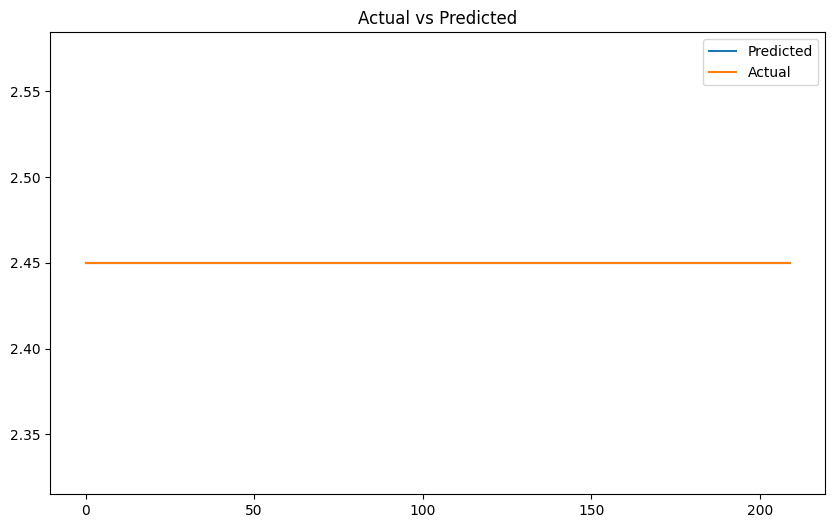

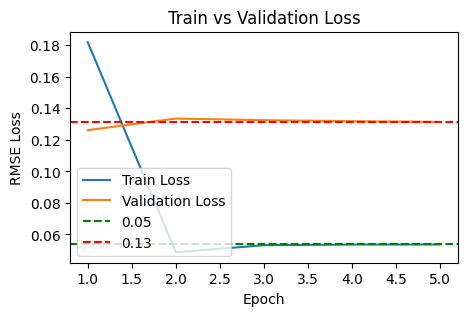

Length train, val: 462, 230.
(442, 20, 14)
(210, 20, 14)


/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


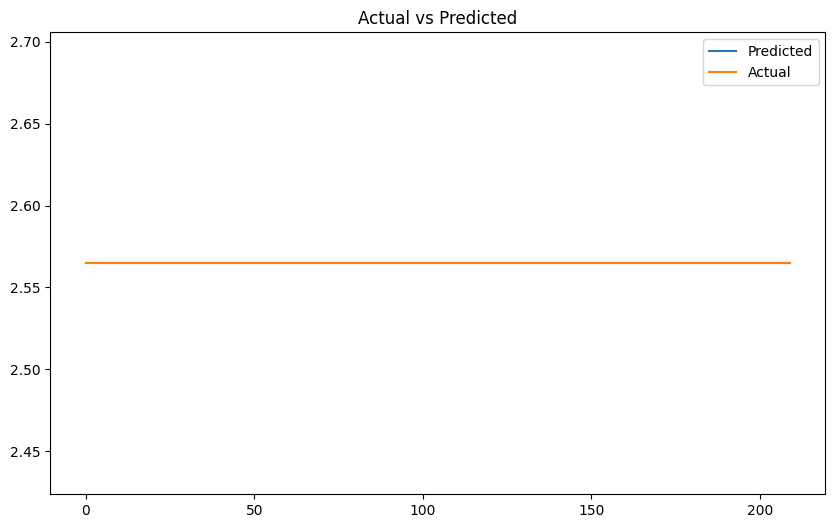

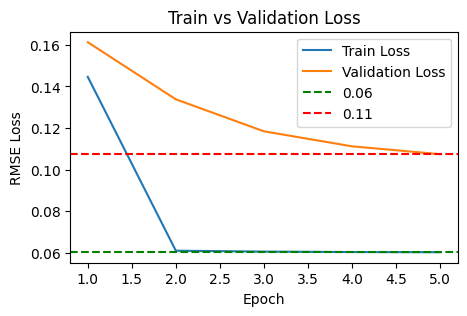

In [123]:
device = torch.device('mps') # torch.device('cpu')
n_splits = 2
split_idx = int(len(df2) * 0.9)
scaler_type = 'minmax' # Standard scaler does not provide good results
batch_size = 1 # Larger batch size takes longer to converge, tried 64 and 32
seq_len = 20
shuffle = False

# FIXME: Assess the model on different sets and use the best one
# TODO: Gap
tscv = TimeSeriesSplit(n_splits=n_splits, gap=0)

# TODO: Assess the models
# Now do CV for assessing robustness, but later on, the train and validation should
# Choose the best model/just go according to the sequential split
print(f"Length train + val, test: {split_idx}, {len(df2) - split_idx}")
for train_idx, val_idx in tscv.split(X.iloc[:split_idx]):
    print(f"Length train, val: {len(train_idx)}, {len(val_idx)}.")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # scaler_x, scaler_y = Scaler(type=scaler_type), Scaler(type=scaler_type)
    # X_train_scaled, X_val_scaled = scaler_x.scale_fit_transform(train=X_train, val=X_val)
    # y_train_scaled, y_val_scaled = scaler_y.scale_fit_transform(
    #     train=np.reshape(y_train, (-1, 1)), 
    #     val=np.reshape(y_val, (-1, 1)))
    
    # train_dataloader = load_data(X=load_sequence(X_train_scaled, seq_len=seq_len), 
    #                              y=y_train_scaled[:-seq_len], batch_size=batch_size, shuffle=shuffle)
    # val_dataloader = load_data(X=load_sequence(X_val_scaled, seq_len=seq_len), 
    #                            y=y_val_scaled[:-seq_len], batch_size=batch_size, shuffle=shuffle)

    train_dataloader = load_data(X=load_sequence(X_train, seq_len=seq_len), 
                                 y=y_train[:-seq_len], batch_size=batch_size, shuffle=shuffle)
    val_dataloader = load_data(X=load_sequence(X_val, seq_len=seq_len), 
                               y=y_val[:-seq_len], batch_size=batch_size, shuffle=shuffle)
    kwargs = {
        'input_size': X.shape[-1],
        'hidden_size': 128 , # 64 and 128 have weird spikes at the end
        'num_layers': 8,
        'train_dataloader': train_dataloader,
        'val_dataloader': val_dataloader
        #'scaler_y': scaler_y
        
    }
    # lr 0.1 is too high, will fluctuate at the end 
    # FIXME: Edit n_epoch
    # model = custom_model(type='RNN', lr=0.0001, n_epoch=100, device=DEVICE, **kwargs) # It's wrong to write kwargs=kwargs
    # model.fit()
    # model.plot_loss()

    model = custom_model(type='LSTM', lr=0.005, n_epoch=5, device=DEVICE, **kwargs) # It's wrong to write kwargs=kwargs
    model.fit()
    model.plot_loss()

# Use the last model with all the training and validation data
test_model = model
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]



# Test another LSTM


https://github.com/Daammon/Stock-Prediction-with-RNN-in-Pytorch/blob/master/Rnn0.ipynb

In [116]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
from pathlib import Path

# X = df2.drop(columns=['Future Close'])
# y = df2['Future Close']

target_col_name = 'A17U.SI_Next_Close'
X = df2.drop(columns=[target_col_name])
y = df2[target_col_name]

# Define the LSTM-based neural network model
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): # FIXME: input size
        super(Model1, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM layer with specified input_size, hidden_size, and num_layers, batch_first ensures
        # that the input and output tensors are provided as (batch, seq, feature)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # Output layer that maps the output of the LSTM to the desired output size
        self.out = nn.Linear(hidden_size, 1)
        # Batch normalization applied to outputs across the batch dimension
        # self.bn = nn.BatchNorm1d(hidden_size)

    # def forward(self, x, h_state, c_state):
    #     # Forward pass through LSTM
    #     r_out, (h_state, c_state) = self.lstm(x, (h_state, c_state))
    #     # Apply batch normalization to the outputs at each time step
    #     # r_out = self.bn(r_out)
    # TODO:
    #     return self.out(r_out[:, -1, :]), (h_state, c_state)
    def forward(self, x):
        # Forward pass through LSTM
        r_out, (h_state, c_state) = self.lstm(x)
        # Apply batch normalization to the outputs at each time step
        # r_out = self.bn(r_out)

        return self.out(r_out[:, -1, :]) #, (h_state, c_state)

# Dataset class that handles loading of data
class StockDataset(Dataset):
    def __init__(self, X_dataset, Y_dataset):
        # Convert the input datasets to tensors
        self.X_dataset = torch.from_numpy(X_dataset).float()
        self.Y_dataset = torch.from_numpy(Y_dataset).float()
        
    def __len__(self):
        # Return the number of samples in the dataset
        return self.X_dataset.size(0)

    def __getitem__(self, idx):
        # Retrieve the sequence and the target value at the given index
        sequence = self.X_dataset[idx, :, :]
        target = self.Y_dataset[idx]

        # print(sequence.shape, target.shape)
        return {'Sequence': sequence, 'Target': target}



# Set hyperparameters
batch_size = 1
hidden_size = 128 # Tried 256 but still step function
num_layers = 8 # Tried 16 but still step function
seq_len = 20
# Initialize the neural network, transfer it to GPU if available
model = Model1(input_size=X.shape[-1], hidden_size=hidden_size, num_layers=num_layers).to(DEVICE)

# Initialize the hidden and cell states of LSTM
h_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)
c_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)

# Define a loss function and the optimizer 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


# train_dataset = StockDataset(load_sequence(X, seq_len), y.to_numpy()) # FIXME: Might have diff length
train_dataloader = load_data(load_sequence(X, seq_len), y[:-seq_len], batch_size, False)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


# Training loop
for epoch in range(2):
    running_loss = 0.0
    pred_list = []
    actual_list = []

    # h_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)
    # c_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)
    model.train()
    # Iterate over the DataLoader for training data
    for i, (inputs, labels) in enumerate(train_dataloader):
        # Changed data to (inputs, labels) without using StockDataset
        # inputs, labels = data['Sequence'], data['Target']
        
        
        # Wrap inputs and labels in Variables, transfer them to GPU if available
        # Deprecated function
        # x = Variable(inputs).to(DEVICE)
        # y = Variable(labels).to(DEVICE)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # TODO:
        # Forward pass, backward pass, and optimize
        # prediction, (h_state, c_state) = model(inputs, h_state, c_state)
        prediction, _ = model(inputs)
        # Get the predictions for the last time step
        # print(prediction)
        prediction = prediction.squeeze()
        # TODO:
        # Detach states from the graph to prevent backpropagation through the entire sequence
        # h_state = Variable(h_state.data)
        # c_state = Variable(c_state.data)
        loss = criterion(prediction, labels)

        loss.backward()
        # nn.utils.clip_grad_norm(model.parameters(), max_norm=2, norm_type=2) 
        # TODO: 
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        for name, param in model.named_parameters():
            # print(f"requires_grad: {param.requires_grad}")
            if param.grad is not None:
                # print(f"Layer: {name} | Max Gradient: {param.grad.data.abs().max()}")
                pass
            else:
                print(f"Gradient is None")
        
        
        optimizer.step()
        
        # Print loss statistics
        running_loss += loss.item()
        if i % 2 == 1:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 2:.7f}')
            running_loss = 0.0
        
        # Store predictions for plotting
        # prediction_plot.extend(prediction.cpu().detach().numpy())
        # For batch size 1
        pred_list.append(prediction.cpu().item())
        actual_list.append(labels.cpu().item())


    # Detach states from computation graph to prevent BPP the entire history
    # h_state = h_state.detach()
    # c_state = c_state.detach()

print('Finished Training')

(749, 20, 14)


/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Batch 2, Loss: 5.6285086
Epoch 1, Batch 4, Loss: 1.2470065
Epoch 1, Batch 6, Loss: 0.2795836
Epoch 1, Batch 8, Loss: 0.1456463
Epoch 1, Batch 10, Loss: 0.3004707
Epoch 1, Batch 12, Loss: 0.1198190
Epoch 1, Batch 14, Loss: 0.0079555
Epoch 1, Batch 16, Loss: 0.0891232
Epoch 1, Batch 18, Loss: 0.0932515
Epoch 1, Batch 20, Loss: 0.0223933
Epoch 1, Batch 22, Loss: 0.0117398
Epoch 1, Batch 24, Loss: 0.0487806
Epoch 1, Batch 26, Loss: 0.0337915
Epoch 1, Batch 28, Loss: 0.0106746
Epoch 1, Batch 30, Loss: 0.0022732
Epoch 1, Batch 32, Loss: 0.0118854
Epoch 1, Batch 34, Loss: 0.0243636
Epoch 1, Batch 36, Loss: 0.0165238
Epoch 1, Batch 38, Loss: 0.0027482
Epoch 1, Batch 40, Loss: 0.0045077
Epoch 1, Batch 42, Loss: 0.0064057
Epoch 1, Batch 44, Loss: 0.0112604
Epoch 1, Batch 46, Loss: 0.0042774
Epoch 1, Batch 48, Loss: 0.0005373
Epoch 1, Batch 50, Loss: 0.0049522
Epoch 1, Batch 52, Loss: 0.0046521
Epoch 1, Batch 54, Loss: 0.0008856
Epoch 1, Batch 56, Loss: 0.0000721
Epoch 1, Batch 58, Loss:

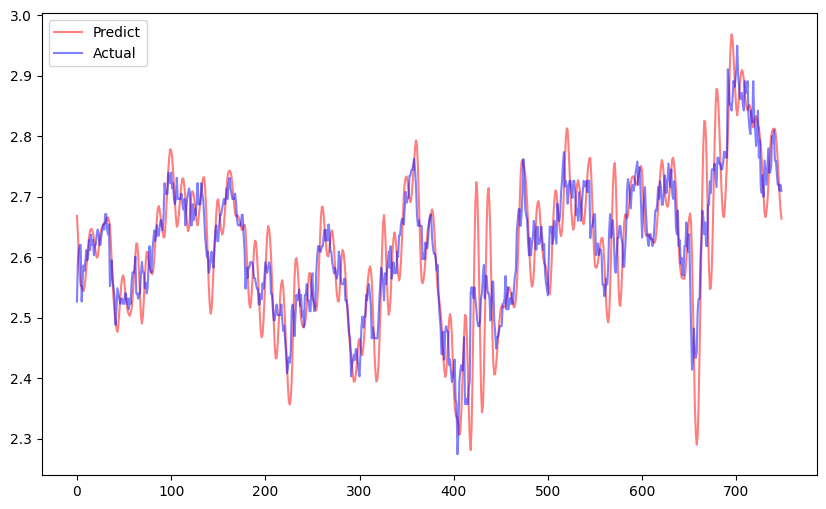

In [117]:
assert len(actual_list) == len(pred_list), "Actual and predicted length different."
# The timing might be different because of the drop last etc.
plt.figure(figsize=(10, 6))
plt.plot(pred_list, label='Predict', c='r', alpha=0.5)
plt.plot(actual_list, label='Actual', c='b', alpha=0.5)
plt.legend()
plt.show()

# LSTM - proper


In [126]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
from pathlib import Path

# X = df2.drop(columns=['Future Close'])
# y = df2['Future Close']

target_col_name = 'A17U.SI_Next_Close'
X = df2.drop(columns=[target_col_name])
y = df2[target_col_name]

# Define the LSTM-based neural network model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): # FIXME: input size
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=0.2,
                            bidirectional=False)
        # Output layer that maps the output of the LSTM to the desired output size
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x, h_state, c_state):
        # Forward pass through LSTM
        r_out, (h_state, c_state) = self.lstm(x, (h_state, c_state))
        return self.out(r_out[:, -1, :]), (h_state, c_state)

# Set hyperparameters
batch_size = 1
hidden_size = 128 # Tried 256 but still step function
num_layers = 8 # Tried 16 but still step function
seq_len = 20
# Initialize the neural network, transfer it to GPU if available
model = LSTM(input_size=X.shape[-1], hidden_size=hidden_size, num_layers=num_layers).to(DEVICE)

# Initialize the hidden and cell states of LSTM
h_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)
c_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)

# Define a loss function and the optimizer 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_dataloader = load_data(load_sequence(X, seq_len), y[:-seq_len], batch_size, False)

# Training loop
for epoch in range(2):
    running_loss = 0.0
    pred_list = []
    actual_list = []

    model.train()
    # Iterate over the DataLoader for training data
    for i, (inputs, labels) in enumerate(train_dataloader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        

        # Forward pass, backward pass, and optimize
        prediction, (h_state, c_state) = model(inputs, h_state, c_state)
        print(prediction.shape, labels.shape)
        # Get the predictions for the last time step
        prediction = prediction.squeeze()
        # Detach states from the graph to prevent backpropagation through the entire sequence
        h_state = Variable(h_state.data)
        c_state = Variable(c_state.data)
        loss = criterion(prediction, labels)

        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=2.0)

        for name, param in model.named_parameters():
            # print(f"requires_grad: {param.requires_grad}")
            if param.grad is not None:
                # print(f"Layer: {name} | Max Gradient: {param.grad.data.abs().max()}")
                pass
            else:
                print(f"Gradient is None")
        
        optimizer.step()
        
        # Print loss statistics
        running_loss += loss.item()
        if i % 2 == 1:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 2:.7f}')
            running_loss = 0.0
        
        # Store predictions for plotting
        pred_list.append(prediction.cpu().item())
        actual_list.append(labels.cpu().item())


    # Detach states from computation graph to prevent BPP the entire history
    h_state = h_state.detach()
    c_state = c_state.detach()

print('Training completed')

(749, 20, 14)
torch.Size([1, 1]) torch.Size([1])


/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 2, Loss: 3.2924051
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 4, Loss: 0.3725396
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 6, Loss: 0.0186705
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 8, Loss: 0.0577922
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 10, Loss: 0.0035677
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 12, Loss: 0.0205976
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 14, Loss: 0.0171225
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 16, Loss: 0.0019689
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 18, Loss: 0.0049314
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
Epoch 1, Batch 20, Loss:

KeyboardInterrupt: 

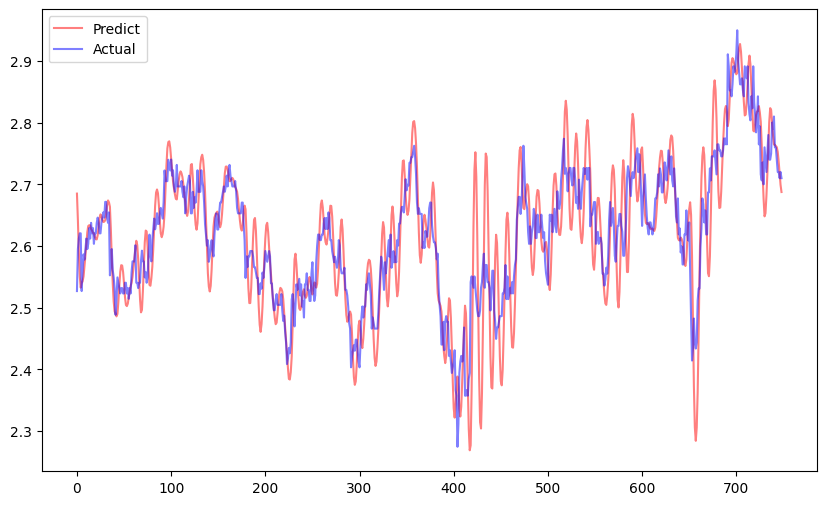

In [125]:
assert len(actual_list) == len(pred_list), "Actual and predicted length different."
# The timing might be different because of the drop last etc.
plt.figure(figsize=(10, 6))
plt.plot(pred_list, label='Predict', c='r', alpha=0.5)
plt.plot(actual_list, label='Actual', c='b', alpha=0.5)
plt.legend()
plt.show()

# Prediction
- Add SHAP values

In [ ]:
# Parameters are similar to that in training
_, X_test_scaled = scale(X_train=X_train, X_val=X_test, type=scaler_type)
test_dataloader = load_data(X=X_test, y=y_test, batch_size=batch_size, shuffle=shuffle)
pred_dict, avg_test_loss = test_model.evaluate(test_dataloader=test_dataloader)


In [ ]:
pred_df = pd.DataFrame(pred_dict)
pred_list = pred_dict['predicted']
actual_list = pred_dict['actual']

from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_true=actual_list, y_pred=pred_list)
print(f"RMSE: {rmse:.5f}, average test loss: {avg_test_loss:.5f} should be similar") 


plt.figure(figsize=(10, 6))
x = range(len(pred_list))

plt.plot(x, pred_list, label='Predicted')
plt.plot(x, actual_list, label='Actual')
plt.title('Actual vs Predicted for Test Data')
plt.legend()
plt.show()

In [ ]:
test_model.model.eval()
X_train_tensor = torch.tensor(X_train_scaled[:1000], dtype=torch.float32).to(DEVICE) # FIXME: Edit size
X_test_tensor = torch.tensor(X_test_scaled[:5], dtype=torch.float32).to(DEVICE)
# Need to use DeepExplainer for PyTorch, instead of Explainer
# Analyse how each feature contributes to the prediction
deepExplainer = shap.DeepExplainer(model=test_model.model, data=X_train_tensor)
# Approximate shap values for the prediction
shap_values = deepExplainer.shap_values(X_test_tensor)

In [ ]:
shap_values_squeezed = np.squeeze(shap_values, axis=2)
shap_values_squeezed.shape
shap.summary_plot(shap_values_squeezed, X_test_tensor)

In [ ]:
X_test_numpy = X_test_tensor.cpu().numpy()
X_test_numpy.shape

In [ ]:
shap.initjs()
# deepExplainer.expected_value = deepExplainer.expected_value[0]
shap.plots.force(deepExplainer.expected_value, shap_values_squeezed, X_test_numpy, matplotlib=False)

Afterwards for really testing against test

In [ ]:
#
# X_train, X_val, y_train, y_val = train_test_split(X.iloc[:split_idx], y.iloc[:split_idx], shuffle=False, test_size=0.2)